In [1]:
import pandas as pd
import numpy as np
from src.eigen_adjust import *
from src.util import *
import matplotlib
from tqdm import tqdm
%matplotlib inline

In [2]:
equ_return_df  = pd.read_csv('equ_return.csv')

In [3]:
equ_return_df.columns

Index(['ID', 'SECURITY_ID', 'TICKER_SYMBOL', 'EXCHANGE_CD', 'TRADE_DATE',
       'LIST_STATUS_CD', 'FIRST_DAY_CLOSE_PRICE', 'ACT_PREV_CLOSE_PRICE',
       'PREV_CLOSE_PRICE', 'CLOSE_PRICE', 'ALLOTMENT_RATIO', 'ALLOTMENT_PRICE',
       'PER_CASH_DIV', 'PER_SHARE_DIV_RATIO', 'PER_SHARE_TRANS_RATIO',
       'SPLITS_RATIO', 'CURRENCY_CD', 'DAILY_RETURN_REINV',
       'DAILY_RETURN_NO_REINV', 'ADJ_CLOSE_PRICE_REINV',
       'ADJ_CLOSE_PRICE_NO_REINV', 'IS_CHG_PCTL', 'ETL_CRC', 'QA_RULE_CHK_FLG',
       'QA_MANUAL_FLG', 'QA_ACTIVE_FLG', 'CREATE_BY', 'CREATE_TIME',
       'UPDATE_BY', 'UPDATE_TIME', 'TMSTAMP'],
      dtype='object')

In [4]:
X = equ_return_df.pivot(index='SECURITY_ID', columns='TRADE_DATE', values='DAILY_RETURN_REINV').fillna(0.)
X = X.values

In [5]:
N, T = X.shape
window_size = 500 # rolling window size
portfolio_weight_dict = {} # 外层为方差排序序号，内层为时间
cov_dict = {} # 时间为key
equity_return_dict = {}

In [6]:
for i in tqdm(range(T-window_size)): # 滚动生成V_0，并且计算eigenvector
    X_tmp = X[:, i:i+window_size]
    equity_return = X[:, i+window_size-1]
    equity_return_dict[i] = equity_return
    V_0 = np.cov(X_tmp, ddof=1)
    cov_dict[i] = V_0
    val, vec = np.linalg.eig(V_0)
    val, vec = sort_eigen_pair(val, vec, sort='ascend')
    for n in range(N):
        eigenvector = vec[:, n]
        if n not in portfolio_weight_dict:
            portfolio_weight_dict[n] = {i:eigenvector}
        else:
            portfolio_weight_dict[n][i] = eigenvector
equity_return_dict[T-window_size] = X[:, -1]

100%|██████████| 402/402 [00:32<00:00, 12.20it/s]


In [7]:
portfolio_bias_test = {}
for ptf_num in tqdm(range(len(portfolio_weight_dict))):
    bias_stats = BiasStats(
            portfolio_weight_dict[ptf_num],
              equity_return_dict,
              cov_dict,
              1.
             )
    B = bias_stats.compute_ptf_bias_stats()
    portfolio_bias_test[ptf_num] = B
portfolio_bias_test_series = pd.Series(portfolio_bias_test)

100%|██████████| 300/300 [00:18<00:00, 16.63it/s]


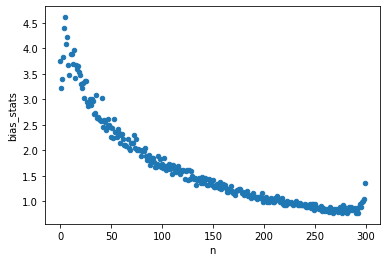

In [36]:
portfolio_bias_test_df = portfolio_bias_test_series.reset_index()
portfolio_bias_test_df.columns = ['n', 'bias_stats']
portfolio_bias_test_df.plot.scatter(x='n', y='bias_stats')

In [35]:
# vec[:, 0]

In [27]:
# val, vec = np.linalg.eig(cov_dict[0])
# val, vec = sort_eigen_pair(val, vec)
# U_0 = np.mat(vec)  # 特征矩阵
# V_0 = np.mat(cov_dict[0])
# D_0 = U_0.T * V_0 * U_0

# vol_bias = compute_sim_vol_bias(U_0, V_0, D_0, 5, window_size)

# gamma = 1.4 * (vol_bias - 1) + 1

# D_tilde_0 = D_0 * np.mat(np.diag(gamma) ** 2)

# V_tilde_0 = U_0 * D_tilde_0 * U_0.T

# V_tilde_0 = V_tilde_0.A


# val1, vec1 = np.linalg.eig(V_tilde_0)
# val1, vec1 = sort_eigen_pair(val1, vec1, sort='ascend')

In [ ]:
# a = np.array([np.nan, 1])

In [16]:
# print(a)
# nan_loc = np.argwhere(np.isnan(a))
# print(nan_loc[0][0])

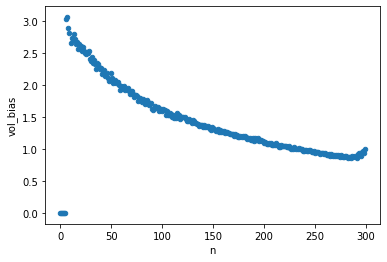

In [37]:
vol_bias_df = vol_bias.reset_index()
vol_bias_df.columns = ['n', 'vol_bias']
vol_bias_df.plot.scatter(x='n', y='vol_bias')

In [17]:
# val.argsort()[::-1]
# portfolio_weight_dict[0][0]

In [38]:
adjusted_cov_dict = {}
for i, cov in tqdm(cov_dict.items()):
    adj_cov = eigen_adjustment(cov, 5, window_size, a=1.4)
    adjusted_cov_dict[i] = adj_cov

  0%|          | 0/402 [00:00<?, ?it/s]/home/casey/axioma-paper/src/eigen_adjust.py:36: RuntimeWarning: invalid value encountered in true_divide
  D_ratio['m_%s' % m] = np.sqrt(np.diag(D_tilde_m) / np.diag(D_m))
100%|██████████| 402/402 [04:44<00:00,  1.41it/s]


In [39]:
adjusted_cov_dict[0]

array([[3.13191854e-04, 4.52962219e-05, 1.34985788e-04, ...,
        0.00000000e+00, 1.27507078e-04, 1.20739079e-05],
       [4.52962219e-05, 5.58127418e-04, 6.54146400e-05, ...,
        0.00000000e+00, 3.96510536e-05, 9.50289529e-06],
       [1.34985788e-04, 6.54146400e-05, 5.80459464e-04, ...,
        0.00000000e+00, 1.70819237e-04, 4.06090887e-05],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.27507078e-04, 3.96510536e-05, 1.70819237e-04, ...,
        0.00000000e+00, 3.42805051e-04, 3.48437349e-05],
       [1.20739079e-05, 9.50289529e-06, 4.06090887e-05, ...,
        0.00000000e+00, 3.48437349e-05, 4.99319066e-04]])

In [30]:
# eigen_adjustment(cov_dict[0], 1, window_size, a=1.4)

In [40]:
portfolio_weight_dict = {}
# after adjust
for i in tqdm(range(T-window_size)): # 滚动生成V_0，并且计算eigenvector
    X_tmp = X[:, i:i+window_size]
#     equity_return = X[:, i+window_size-1]
#     equity_return_dict[i] = equity_return
    V_0 = adjusted_cov_dict[i]
    val, vec = np.linalg.eig(V_0)
    val, vec = sort_eigen_pair(val, vec, sort='ascend')
    for n in range(N):
        eigenvector = vec[:, n]
        if n not in portfolio_weight_dict:
            portfolio_weight_dict[n] = {i:eigenvector}
        else:
            portfolio_weight_dict[n][i] = eigenvector
# equity_return_dict[T-window_size] = X[:, -1]

100%|██████████| 402/402 [00:35<00:00, 11.34it/s]


In [21]:
val, vec = np.linalg.eig(adjusted_cov_dict[0])
val, vec = sort_eigen_pair(val, vec, sort='ascend')

In [44]:
portfolio_bias_test = {}
for ptf_num in tqdm(range(len(portfolio_weight_dict))):
    bias_stats = BiasStats(
            portfolio_weight_dict[ptf_num],
              equity_return_dict,
              adjusted_cov_dict,
              1.
             )
    B = bias_stats.compute_ptf_bias_stats()
    portfolio_bias_test[ptf_num] = B
portfolio_bias_test_series = pd.Series(portfolio_bias_test)

100%|██████████| 300/300 [00:22<00:00, 13.40it/s]


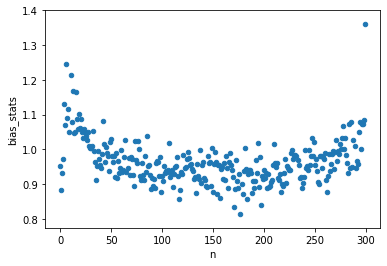

In [45]:
portfolio_bias_test_df = portfolio_bias_test_series.reset_index()
portfolio_bias_test_df.columns = ['n', 'bias_stats']
portfolio_bias_test_df.plot.scatter(x='n', y='bias_stats')